In [9]:
import pandas as pd
data = pd.read_csv('/content/block.csv')

### Dataset

In [10]:
# Dropping rows with any missing values
data_dropped = data.dropna()

# Filling the remaining missing values with a specific value, for example, filling NaNs with 0
data_processed = data_dropped.fillna(0)

# Displaying the processed data
print(data_processed.head())

  member_name                     email  gender   location   employer  \
0       Chipi        ajimmison0@sun.com  female     Kwekwe       Vipe   
1       Femba     rsoonhouse1@google.it  female  Marondera       Mudo   
2        Geta  bchecchetelli2@house.gov  female     Rusape     Skaboo   
3    Tichaona          mgarman3@psu.edu  female     Rusape  Babbleset   
4       Chisa     ccough4@biglobe.ne.jp  female   Bulawayo   Flipopia   

  relationship patient_name  patient_suffix patient_dob  \
0  Grandfather      Mabhena             789  09-11-1997   
1      Husband      Sithole             860   1/14/1992   
2       Mother        Chipi             374  07-03-1999   
3       Father       Jembwa             729   7/31/1978   
4       Father         Foto             716  12/28/1992   

                   cause  Fee_Charged  membership_period  number_of_claims  \
0                  Other         3798               1541                 2   
1                  Other        48905             

### Feature Extraction using PCA

In [11]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [12]:
# Extract the numeric columns for feature extraction
numeric_columns = ['patient_suffix','Fee_Charged','membership_period','number_of_claims','number_of_dependants','label']

# Select the numeric columns for feature extraction
X = data[numeric_columns]

# Apply feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA for dimensionality reduction
num_components = 5
pca = PCA(n_components=num_components)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame with the extracted PCA features
pca_columns = [f'PCA_{i+1}' for i in range(num_components)]
pca_df = pd.DataFrame(data=X_pca, columns=pca_columns)

# Define meaningful names for the actual columns
actual_column_names = ['patient_suffix','Fee_Charged','membership_period','number_of_claims','number_of_dependants','label']

# Define the mapping of PCA feature columns to actual names based on their index
pca_feature_mapping = {
    pca_columns[i]: actual_column_names[i] + '_PCA' for i in range(num_components)
}


pca_df.rename(columns=pca_feature_mapping, inplace=True)

final_df_with_actual_names = pd.concat([data, pca_df], axis=1)

print("Final DataFrame with actual column names for PCA features:")
print(final_df_with_actual_names.head())


Final DataFrame with actual column names for PCA features:
  member_name                     email  gender   location   employer  \
0       Chipi        ajimmison0@sun.com  female     Kwekwe       Vipe   
1       Femba     rsoonhouse1@google.it  female  Marondera       Mudo   
2        Geta  bchecchetelli2@house.gov  female     Rusape     Skaboo   
3    Tichaona          mgarman3@psu.edu  female     Rusape  Babbleset   
4       Chisa     ccough4@biglobe.ne.jp  female   Bulawayo   Flipopia   

  relationship patient_name  patient_suffix patient_dob  \
0  Grandfather      Mabhena             789  09-11-1997   
1      Husband      Sithole             860   1/14/1992   
2       Mother        Chipi             374  07-03-1999   
3       Father       Jembwa             729   7/31/1978   
4       Father         Foto             716  12/28/1992   

                   cause  Fee_Charged  membership_period  number_of_claims  \
0                  Other         3798               1541             

### Feature selection using RFE

In [13]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

# Assuming 'final_df_with_actual_names' contains the DataFrame after PCA and feature concatenation

# Extract only numeric columns for feature selection
numeric_columns = final_df_with_actual_names.select_dtypes(include=['float64', 'int64']).columns
features = final_df_with_actual_names[numeric_columns]

# Remove the target column from features if it's included
target_column = 'label'
if target_column in features:
    features = features.drop(columns=[target_column])

# Initialize the model for feature selection (Random Forest Classifier)
model = RandomForestClassifier()

# Initialize Recursive Feature Elimination (RFE)
num_features_to_select = 3  # Number of features to select
rfe = RFE(model, n_features_to_select=num_features_to_select)

# Fit RFE to the data
rfe.fit(features, final_df_with_actual_names[target_column])

# Get the selected features
selected_features = features.columns[rfe.support_]

selected_features_data = final_df_with_actual_names[selected_features]

# Print selected features along with their values
print(selected_features_data)

      patient_suffix_PCA  membership_period_PCA  number_of_dependants_PCA
0              -2.470795               0.586079                  0.261783
1               0.670615              -0.918131                 -1.221584
2               1.066120              -0.954638                 -0.369856
3               0.300790              -1.221016                 -0.502278
4               2.345037               0.553252                  0.636738
...                  ...                    ...                       ...
6995           -0.244741              -0.810280                 -0.038120
6996            0.719844               0.293486                 -0.581801
6997            0.553308              -0.867162                  0.200764
6998            1.399607               0.291712                  1.412718
6999           -0.984866              -0.161180                 -0.468776

[7000 rows x 3 columns]


In [14]:
!pip install scikit-multiflow

### AdaBoost

In [15]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split


# Splitting data into features and target
X = final_df_with_actual_names[selected_features]
y = final_df_with_actual_names['label']

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Decision Tree classifier
tree_classifier = DecisionTreeClassifier()

# Initialize AdaBoost with DecisionTree as base classifier
adaboost_classifier = AdaBoostClassifier(base_estimator=tree_classifier, n_estimators=50, learning_rate=1.0)

# Train the classifier
adaboost_classifier.fit(X_train, y_train)

# Predict using the trained AdaBoost classifier
predictions = adaboost_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)

# Calculate Sensitivity and Specificity from the confusion matrix (assuming binary classification)
true_negatives, false_positives, false_negatives, true_positives = conf_matrix.ravel()

sensitivity = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

# Calculate Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE)
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)

print("Accuracy:", accuracy)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)


Accuracy: 0.995
Sensitivity: 0.9851301115241635
Specificity: 0.9973474801061007
Root Mean Squared Error (RMSE): 0.07071067811865475
Mean Absolute Error (MAE): 0.005


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


### DecisionTree

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, mean_absolute_error

# Splitting data into features and target
X = final_df_with_actual_names[selected_features]
y = final_df_with_actual_names['label']

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Decision Tree classifier
tree_classifier = DecisionTreeClassifier()

# Train the classifier
tree_classifier.fit(X_train, y_train)

# Predict using the trained Decision Tree classifier
predictions = tree_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)

# Calculate Sensitivity and Specificity from the confusion matrix (assuming binary classification)
true_negatives, false_positives, false_negatives, true_positives = conf_matrix.ravel()

sensitivity = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

# Calculate Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE)
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)

print("Accuracy:", accuracy)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)


Accuracy: 0.9942857142857143
Sensitivity: 0.9851301115241635
Specificity: 0.9964633068081344
Root Mean Squared Error (RMSE): 0.07559289460184544
Mean Absolute Error (MAE): 0.005714285714285714


### GaussianNB

In [17]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, mean_absolute_error


# Splitting data into features and target
X = final_df_with_actual_names[selected_features]
y = final_df_with_actual_names['label']

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Gaussian Naive Bayes classifier
nb_classifier = GaussianNB()

# Train the classifier
nb_classifier.fit(X_train, y_train)

# Predict using the trained Naive Bayes classifier
predictions = nb_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)

# Calculate Sensitivity and Specificity from the confusion matrix (assuming binary classification)
true_negatives, false_positives, false_negatives, true_positives = conf_matrix.ravel()

sensitivity = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

# Calculate Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE)
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)

print("Accuracy:", accuracy)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)


Accuracy: 0.9978571428571429
Sensitivity: 0.9888475836431226
Specificity: 1.0
Root Mean Squared Error (RMSE): 0.04629100498862757
Mean Absolute Error (MAE): 0.002142857142857143


### GradientBoosting

In [18]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, mean_absolute_error

# Assuming 'final_df_with_actual_names' contains the DataFrame after PCA and feature concatenation
# Assuming 'selected_features' contains the selected features for modeling
# Assuming 'label' is the target column

# Splitting data into features and target
X = final_df_with_actual_names[selected_features]
y = final_df_with_actual_names['label']

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Gradient Boosting classifier
gb_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

# Train the classifier
gb_classifier.fit(X_train, y_train)

# Predict using the trained Gradient Boosting classifier
predictions = gb_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)

# Calculate Sensitivity and Specificity from the confusion matrix (assuming binary classification)
true_negatives, false_positives, false_negatives, true_positives = conf_matrix.ravel()

sensitivity = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

# Calculate Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE)
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)

print("Accuracy:", accuracy)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)


Accuracy: 0.9992857142857143
Sensitivity: 0.9962825278810409
Specificity: 1.0
Root Mean Squared Error (RMSE): 0.02672612419124244
Mean Absolute Error (MAE): 0.0007142857142857143


### Ensemble Model

In [19]:
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, mean_absolute_error

# Splitting data into features and target
X = final_df_with_actual_names[selected_features]
y = final_df_with_actual_names['label']

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize individual classifiers
ada_classifier = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), n_estimators=100, random_state=42)
dt_classifier = DecisionTreeClassifier(max_depth=5, random_state=42)
gnb_classifier = GaussianNB()
gb_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

# Create a voting ensemble using the individual classifiers
voting_classifier = VotingClassifier(
    estimators=[
        ('AdaBoost', ada_classifier),
        ('DecisionTree', dt_classifier),
        ('GaussianNB', gnb_classifier),
        ('GradientBoosting', gb_classifier)
    ],
    voting='hard'  # 'hard' voting takes the majority of votes, 'soft' voting computes the argmax of the sums of predicted probabilities
)

# Train the voting ensemble
voting_classifier.fit(X_train, y_train)

# Predict using the trained voting ensemble
predictions = voting_classifier.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, predictions)
conf_matrix = confusion_matrix(y_test, predictions)
true_negatives, false_positives, false_negatives, true_positives = conf_matrix.ravel()
sensitivity = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)

print("Metrics for Voting Classifier:")
print("Accuracy:", accuracy)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Metrics for Voting Classifier:
Accuracy: 0.9985714285714286
Sensitivity: 0.9925650557620818
Specificity: 1.0
Root Mean Squared Error (RMSE): 0.03779644730092272
Mean Absolute Error (MAE): 0.0014285714285714286


### Confusion Matrix

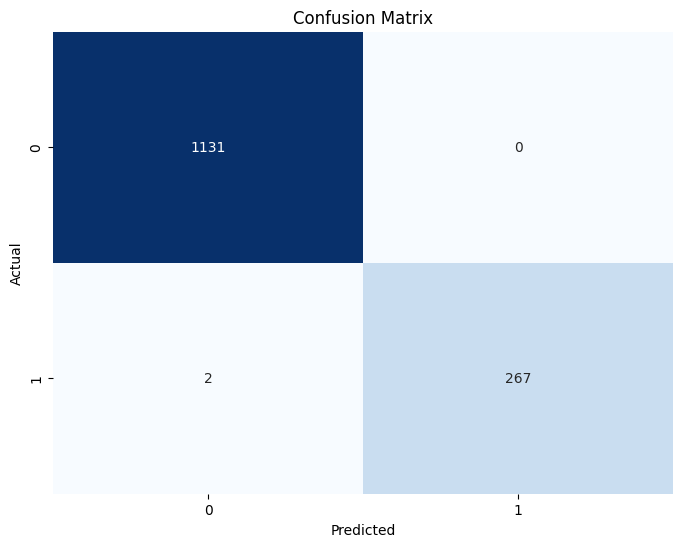

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()